#Project : Nestle

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

Link to our github = https://github.com/NFroehl/DMML2021_Nestle

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/ih8JU9mvJic" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Here are the important libraries that we will use

In [2]:
# Install and update spaCy
!pip install -U spacy

# Download the french language model
!python -m spacy download fr

     |████████████████████████████████| 6.0 MB 17.1 MB/s 
     |████████████████████████████████| 451 kB 43.3 MB/s 
     |████████████████████████████████| 628 kB 47.6 MB/s 
     |████████████████████████████████| 181 kB 57.0 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 10.1 MB 46.4 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
⚠ As of spaCy v3.0, shortcuts like 'fr' are d

In [3]:
# Libraries:

import pandas as pd
import numpy as np
import spacy
import string
from spacy.lang.fr.stop_words import STOP_WORDS
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

#1) Data Preparation

##a) Import Data

First, we read the Training Data using the download link.

In [4]:
# Read the data:

# We take the url to download the training data:

url = "https://raw.githubusercontent.com/NFroehl/DMML2021_Nestle/74eb14159f5f045d427350358637df31b81ea73b/data/training_data.csv"
Training_Data = pd.read_csv(url, delimiter=",")
Training_Data.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


We get some informations about the Training Data in order to see how good they are.

In [5]:
Training_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4800 non-null   int64 
 1   sentence    4800 non-null   object
 2   difficulty  4800 non-null   object
dtypes: int64(1), object(2)
memory usage: 112.6+ KB


In [6]:
np.random.seed = 0

In [7]:
# Base rate: the data-set is balanced
Training_Data.difficulty.value_counts()/Training_Data.shape[0] #the baserate is 0.16973

A1    0.169375
C2    0.168125
C1    0.166250
A2    0.165625
B1    0.165625
B2    0.165000
Name: difficulty, dtype: float64

Then, we read the Test Data using also the download link.

In [8]:
url = "https://raw.githubusercontent.com/NFroehl/DMML2021_Nestle/main/data/unlabelled_test_data.csv"
Test_Data = pd.read_csv(url, delimiter=",")
Test_Data.head(2)
#Test_Data.sentence.shape

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...


##b) Vectorize Data

To do the regression, even without cleaning the data, we need a tokenizer function.

In [9]:
# Let's implement the tokenizer function:

# Load French language model:
sp = spacy.load('fr_core_news_sm')

# Tokenizer function:
def spacy_tokenizer1(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)
    # Return list of tokens
    return mytokens

#2) Classification without Data Cleaning

For each method, we will do hyperparametrization for the TfidVectorizer() function. We will do it on the analyzers word and char.

In [10]:
# To compare all methods, we will create a list of accuracies depending on parameters and methods:
TotalResult = []

##a) Split Data

In [11]:
# Select features
X = Training_Data['sentence'] # the features we want to analyze
y = Training_Data['difficulty'] # the labels, or answers, we want to test against

In [12]:
# Import train/test split function
from sklearn.model_selection import train_test_split

# Train/test splitting code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

##b) Function to evaluate the following models

In [13]:
# Evaluate the models
def evaluate(true, pred):
    precision = precision_score(true, pred, average='macro')
    recall = recall_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

##c) Classification of the reviews using Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Define list for result
analyzer = ['word', 'char']
result = []

for x in analyzer:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer1, 
                                   analyzer=x)

    # Define classifier
    classifier = LogisticRegression()

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("Analyzer: ", x)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([x, accuracy_score(y_test, y_pred)])

Analyzer:  word
CONFUSION MATRIX:
[[  0   0   0   0   0 174]
 [  0   0   0   0   0 161]
 [  0   0   0   0   0 159]
 [  0   0   0   0   0 154]
 [  0   0   0   0   0 160]
 [  0   0   0   0   0 152]]
ACCURACY SCORE:
0.1583
CLASSIFICATION REPORT:
	Precision: 0.0264
	Recall: 0.1667
	F1_Score: 0.0456
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Analyzer:  char
CONFUSION MATRIX:
[[113  25  17  12   2   5]
 [ 38  57  43   8   4  11]
 [ 17  31  54  21  12  24]
 [ 11   1  11  51  34  46]
 [  1   1  10  35  59  54]
 [  4   2   9  18  26  93]]
ACCURACY SCORE:
0.4448
CLASSIFICATION REPORT:
	Precision: 0.4430
	Recall: 0.4425
	F1_Score: 0.4366
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [15]:
TotalResult.append(result)
result

[['word', 0.15833333333333333], ['char', 0.44479166666666664]]

##d) Classification of the reviews using KNN Regression

First, we tun hyperparameters with GridSearch (for n_neighbors, p and weights).

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define parameters to test
grid = {'n_neighbors':np.arange(1,7),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }

# Define and fit model
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=10)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', knn_cv)])
pipe.fit(X_train, y_train)

nb = knn_cv.best_params_['n_neighbors']
p = knn_cv.best_params_['p']
w = knn_cv.best_params_['weights']

# Print results
print("Hyperparameters:", knn_cv.best_params_)
print("Train Score:", round(knn_cv.best_score_, 4))

Hyperparameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Train Score: 0.3539


And we do the regression with the best parameters.

In [17]:
# Define list for result
analyzer = ['word', 'char']
result = []

for x in analyzer:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer1, 
                                   analyzer=x)

    # Define classifier
    classifier = KNeighborsClassifier(n_neighbors=nb, p = p, weights = w)

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("Analyzer: ", x)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([x, accuracy_score(y_test, y_pred)])

Analyzer:  word
CONFUSION MATRIX:
[[174   0   0   0   0   0]
 [161   0   0   0   0   0]
 [159   0   0   0   0   0]
 [154   0   0   0   0   0]
 [160   0   0   0   0   0]
 [152   0   0   0   0   0]]
ACCURACY SCORE:
0.1812
CLASSIFICATION REPORT:
	Precision: 0.0302
	Recall: 0.1667
	F1_Score: 0.0511
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Analyzer:  char
CONFUSION MATRIX:
[[84 38 27  7  6 12]
 [28 50 39 21 11 12]
 [23 25 39 31 21 20]
 [ 4 10 20 31 47 42]
 [ 3  4 14 22 54 63]
 [ 1  4  7 18 46 76]]
ACCURACY SCORE:
0.3479
CLASSIFICATION REPORT:
	Precision: 0.3507
	Recall: 0.3462
	F1_Score: 0.3438
-----------------------


In [18]:
TotalResult.append(result)
result

[['word', 0.18125], ['char', 0.34791666666666665]]

##e) Classification of the reviews using Decision Tree Regression

First, we tun hyperparameters with GridSearch (for depth).

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Grid Search - tuning tree depth

# Define parameter to test
grid = {'max_depth':np.arange(1,10)}

# Define and fit model

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, grid, cv=5)

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', tree_cv)])
pipe.fit(X_train, y_train)

d = tree_cv.best_params_

# Print results
print("Hyperparameters:", tree_cv.best_params_)
print("Train Score:", round(tree_cv.best_score_, 4))

Hyperparameters: {'max_depth': 6}
Train Score: 0.3586


And we do the regression with the best parameter.

In [20]:
# Define list for result
analyzer = ['word', 'char']
result = []

for x in analyzer:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer1, 
                                   analyzer=x)

    # Define classifier
    classifier = DecisionTreeClassifier(max_depth=6, random_state=72) #best parameter we found

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("Analyzer: ", x)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([x, accuracy_score(y_test, y_pred)])

Analyzer:  word
CONFUSION MATRIX:
[[  0   0   0   0   0 174]
 [  0   0   0   0   0 161]
 [  0   0   0   0   0 159]
 [  0   0   0   0   0 154]
 [  0   0   0   0   0 160]
 [  0   0   0   0   0 152]]
ACCURACY SCORE:
0.1583
CLASSIFICATION REPORT:
	Precision: 0.0264
	Recall: 0.1667
	F1_Score: 0.0456
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Analyzer:  char
CONFUSION MATRIX:
[[84 43 40  4  0  3]
 [31 44 74  9  0  3]
 [ 8 23 99 13 12  4]
 [ 4  6 45 40 40 19]
 [ 2  3 29 30 63 33]
 [ 1  2 29 13 52 55]]
ACCURACY SCORE:
0.4010
CLASSIFICATION REPORT:
	Precision: 0.4229
	Recall: 0.3990
	F1_Score: 0.3967
-----------------------


In [21]:
TotalResult.append(result)
result

[['word', 0.15833333333333333], ['char', 0.4010416666666667]]

##f) Classification of the reviews using Random Forest Regression

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define list for result
analyzer = ['word', 'char']
result = []

for x in analyzer:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer1, 
                                   analyzer=x)

    # Define classifier
    classifier = RandomForestClassifier(n_estimators=100)

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("Analyzer: ", x)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([x, accuracy_score(y_test, y_pred)])

Analyzer:  word
CONFUSION MATRIX:
[[  0   0   0 174   0   0]
 [  0   0   0 161   0   0]
 [  0   0   0 159   0   0]
 [  0   0   0 154   0   0]
 [  0   0   0 160   0   0]
 [  0   0   0 152   0   0]]
ACCURACY SCORE:
0.1604
CLASSIFICATION REPORT:
	Precision: 0.0267
	Recall: 0.1667
	F1_Score: 0.0461
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Analyzer:  char
CONFUSION MATRIX:
[[110  38  20   3   2   1]
 [ 42  65  38   7   4   5]
 [ 15  39  58  23  10  14]
 [  4  11  20  63  36  20]
 [  2   3  12  42  57  44]
 [  3   3  10  23  39  74]]
ACCURACY SCORE:
0.4448
CLASSIFICATION REPORT:
	Precision: 0.4409
	Recall: 0.4421
	F1_Score: 0.4414
-----------------------


In [23]:
TotalResult.append(result)
result

[['word', 0.16041666666666668], ['char', 0.44479166666666664]]

##g) Results

Let's compare our previous results to choose which method we are going to keep for the next part (with data cleaning).

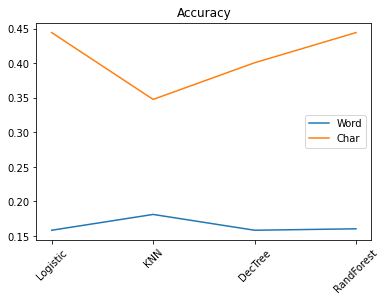

In [24]:
# I import the library that I need to plot :
import matplotlib.pyplot as plt

# I build the lists which contains the accuracy for each method :
n = len(TotalResult)
TestAccuracyWord = [TotalResult[i][0][1] for i in range(n)]
TestAccuracyChar = [TotalResult[i][1][1] for i in range(n)]
x = [i for i in range(1,n+1)]

# I plot the lists and I put a name for each point :
labels = ['Logistic', 'KNN', 'DecTree', 'RandForest']

plt.title('Accuracy')
plt.plot(x, TestAccuracyWord, label = 'Word')
plt.plot(x, TestAccuracyChar, label = 'Char')
plt.legend()
plt.xticks(x, labels, rotation = 45)

plt.show()

In [25]:
TotalResult

[[['word', 0.15833333333333333], ['char', 0.44479166666666664]],
 [['word', 0.18125], ['char', 0.34791666666666665]],
 [['word', 0.15833333333333333], ['char', 0.4010416666666667]],
 [['word', 0.16041666666666668], ['char', 0.44479166666666664]]]

|                     | Logistic regression |       KNN        |   Decision Tree      |   Random Forest     |
| ------------------- | ------------------- |----------------- | -------------------- |-------------------- |
| Precision           | 0.4430              | 0.3507           | 0.4229               |  0.4236             | 
| Recall              | 0.4425              | 0.3462           | 0.3990               |  0.4277             | 
| F1-Score            | 0.4366              | 0.3438           | 0.3967               |  0.4248             | 
| Accuracy            | 0.4448              | 0.3479           | 0.4010               |  0.4313             |  


According to the list and the graph, we decide to continue to work with Logistic Regression and Analyzer = 'char'. Random Forest has also a very good accuracy. Maybe we will try it too.

#3) Classification with Data Cleaning

##a) Data Cleaning function et vectorization

We use nltk package for cleaning

In [26]:
#other tokenizer function

#importing package
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords


# Define cleaning function
def data_cleaner(sms):

    # Define stopwords
    stop_words = stopwords.words('french')

    # Define tokenizer and stemmer
    from nltk.tokenize import word_tokenize
    from nltk.stem import PorterStemmer
    
    # Remove digits
    sms = re.sub(r"\d+","", sms)
    
    # Lowercase
    sms = sms.lower()
    
    # Remove punctuation
    sms = re.sub(r"[^\w\s\d]","", sms)

   # Remove stop words
    sms = sms.split()
    sms = " ".join([word for word in sms if not word in stop_words])
    
    # Tokenize
    sms = word_tokenize(sms)
    
    # Stemming
    ps = PorterStemmer()
    sms = [ps.stem(word) for word in sms]
    
    return sms 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [27]:
#Clean X_train 
X_train.apply(data_cleaner)

3925    [jai, vu, cett, grand, imag, litali, relev, fa...
2070    [cett, somm, comprend, dépens, délectricité, c...
4211                 [ira, voir, maman, semain, prochain]
1452    [cadr, dune, recherch, sociolinguistiqu, urbai...
1881                                   [just, petit, peu]
                              ...                        
3079    [aristocr, naissanc, haîssait, instinct, quatr...
3951                                         [jai, froid]
2885    [rien, dextraordinair, quand, vit, sud, leurop...
3941    [éclair, cett, lueur, chemin, crépusculair, mè...
4568    [quartier, certain, voisin, sentend, ouvrir, p...
Name: sentence, Length: 3840, dtype: object

It is not perfect mais already great. We further use DOC2VEC to vectorize

In [28]:
#
from gensim.models.doc2vec import TaggedDocument
sample_tagged = Training_Data.apply(lambda r: TaggedDocument(words=data_cleaner(r['sentence']), tags=[r.difficulty]),axis=1)
#test_tagged = Test_Data.apply(lambda r: TaggedDocument(words=data_cleaner(r['sentence']), tags = None), axis=1)


In [29]:
sample_tagged.values[10]

TaggedDocument(words=['bonjour', 'bonn', 'anné'], tags=['A1'])

In [30]:
# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=1234)

In [31]:
test_tagged

4448    ([avant, laisser, parol, monsieur, servat, sau...
3022    ([quand, reviendrai, joffrirai, beaucoup, damo...
827                         ([beau, succè, destim], [C1])
1745    ([clore, cett, monographi, café, constantinopo...
4202    ([lune, plu, emblématiqu, mari, sophi, germain...
                              ...                        
3640                 ([jai, mangé, hamburg, frite], [A1])
2229    ([organisé, loccas, e, anniversair, mort, poèt...
319     ([noter, lapprentissag, grammair, français, ob...
4697    ([lorigin, politiqu, sen, modern, mot, europ, ...
1416    ([grand, maison, chien, poisson, deux, chat], ...
Length: 960, dtype: object

In [32]:
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

In [33]:

# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, workers=cores, epoch=300)
model_dbow.build_vocab([x for x in sample_tagged.values])


We now train the distributed bag of words model. In short, it trains a neural network and the optimal weights are the coefficients of the vectors of the documents. Therefore, similar documents will be close to each other in the N-dimentional space (N being the size of the vectors).

In [34]:
# Train distributed Bag of Word model
model_dbow.train(sample_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [35]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
    return targets, regressors
    
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [36]:
X_train[:2]

(array([ 0.6667536 ,  0.45943913,  0.9231648 ,  0.6262274 ,  0.8101322 ,
        -1.5293343 , -0.6496407 ,  0.2634992 , -0.43449134, -1.2049559 ,
        -0.6963653 ,  0.27937326,  1.1597662 , -1.5181923 , -0.5547148 ,
         0.892161  ,  1.0147766 ,  0.17524172, -0.03141254, -0.24716906,
        -0.6262303 , -0.5923636 , -0.564288  , -0.0261508 , -0.68742293,
         0.8222808 , -0.15059598,  0.3094909 ,  0.49820966, -0.8700862 ],
       dtype=float32),
 array([ 0.10976168,  0.5574261 ,  0.97065306,  0.20477302,  0.84949   ,
        -1.5403055 , -0.8254989 ,  0.33958933, -0.7849252 , -1.0262086 ,
        -0.4726402 ,  0.24633859,  0.98761874, -1.3966749 , -0.26298088,
         0.9560074 ,  1.0133266 ,  0.38569626,  0.39685905, -0.08385041,
        -0.7104017 , -0.5186276 , -0.56405306,  0.38454774, -0.62479424,
         1.020243  , -0.03280168,  0.03861826,  0.43135014, -0.8077871 ],
       dtype=float32))

## b) Logistic Regression with DOC2VEC

In [37]:
# Fit model on training set
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

In [38]:
# Print accuracy on test set 
evaluate(y_test, y_pred)
#we have an accuracy of 0.7333

CONFUSION MATRIX:
[[131  21  10   2   1   1]
 [ 40  88  26   1   1   0]
 [ 17  27 113   9   0   1]
 [  3   1  11 119  14   7]
 [  3   2   1  17 124  10]
 [  0   0   6   7   9 137]]
ACCURACY SCORE:
0.7417
CLASSIFICATION REPORT:
	Precision: 0.7439
	Recall: 0.7415
	F1_Score: 0.7415


|                     | Logistic regression |       KNN        |   Decision Tree      |   Random Forest     |Doc2Vec with Log Reg|
| ------------------- | ------------------- |----------------- | -------------------- |-------------------- | -------------------|
| Precision           | 0.4430              | 0.3507           | 0.4229               |  0.4236             |  0.7404            |
| Recall              | 0.4425              | 0.3462           | 0.3990               |  0.4277             |  0.7391            |
| F1-Score            | 0.4366              | 0.3438           | 0.3967               |  0.4248             |  0.7392            |
| Accuracy            | 0.4448              | 0.3479           | 0.4010               |  0.4313             |  0.7385            |


#4) Final Classifation for Kaggle

To get a better accuracy, we use the whole Train Data to do the final regression.


In [39]:
# Train distributed Bag of Word model
model_dbow.train(sample_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [40]:
#prepare train data
y_train_Kaggle, X_train_Kaggle = vec_for_learning(model_dbow, sample_tagged)

In [41]:
#prepare test data

test_tagged = Test_Data.apply(lambda r: TaggedDocument(words=data_cleaner(r['sentence']), tags = None), axis=1)

In [42]:
# To prepare the test data
def vec_for_predicting(model, tagged_docs):
    sents = tagged_docs.values
    regressors = [(model.infer_vector(doc.words, steps=100)) for doc in sents]
    return regressors

In [43]:

X_test_Kaggle = vec_for_predicting(model_dbow, test_tagged)

In [44]:
# Fit model on training set
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train_Kaggle, y_train_Kaggle)

LogisticRegression(max_iter=1000)

In [45]:
#prediction
LogRegPred = logreg.predict(X_test_Kaggle)

In [46]:
LogisticReg_pred = pd.DataFrame(LogRegPred)

In [47]:
LogisticReg_pred.columns = ['difficulty']
LogisticReg_pred.insert(0, 'id', [i for i in range(1200)])

In [48]:
LogisticReg_pred.to_csv('LogisticReg_prediction.csv', header = True, index = False)